<a href="https://colab.research.google.com/github/roopalJazz/AIML/blob/master/1_KNN_weight_sphericity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="M0W1_EXP_3_KNN_weight_sphericity" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/kNN_weight_sphericity_train.csv")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/kNN_weight_sphericity_test.csv")
  
    print ("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook}

      r = requests.post(url, data = data)
      r = json.loads(r.text)
      print("Your submission is successful.")
      print("Ref Id:", submission_id)
      print("Date of submission: ", r["date"])
      print("Time of submission: ", r["time"])
      print("View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions")
      print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getAnswer():
  try:
    return Answer
  except NameError:
    print ("Please answer Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
  
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


In this experiment, we will use the data set on fruits which we explored earlier and learn how a simple K nearest neighbour classification works. 

Let us consider a simple situation. Given some data about a fruit, we want to label it automatically.

Fruits are characterized by 
 * weight in grams as a float
 * sphericity in mm as a float
 * label as a string
     - "A" $\rightarrow$ Apple
     - "O" $\rightarrow$ Orange
     
We are given some sample data such as (303, 3, "A") meaning the fruit with 303 gram weight, and yellow colour is an apple. A set of such *training samples* is given in “kNN_weight_sphericity_train.csv”. 

We are given a set of **test** data where only weight and colour are given,  eg. (373,1). We should design a simple Nearest Neighbour classifier that will find the fruit label. i.e., "A" or "O", meaning Apple or Orange. 

We have several such testcases, split into train and test. We try to see if our predictions are fine on test data.


In [0]:
## Let us set up the file names
FRUITS_TRAIN = "kNN_weight_sphericity_train.csv"
FRUITS_TEST1 = "kNN_weight_sphericity_test.csv"



In [13]:
# Let us first read the data from the file and do a quick visualization
import pandas as pd
train = pd.read_csv(FRUITS_TRAIN)
train

,Weight,Sphericity,Label
0,200,0.400,A
1,320,1.000,O
2,310,0.950,O
3,220,0.450,A
4,230,0.500,A
5,245,0.400,A
6,240,0.350,A
7,330,0.980,O
8,315,0.900,O
9,243,0.530,A


We  see that similar fruits come close in the feature (weight, color) space? Now let us plot one sample data given in black.

In [0]:
import matplotlib.pyplot as plt

In [0]:
apples=train[train['Label']=='A']
oranges=train[train['Label']=='O']

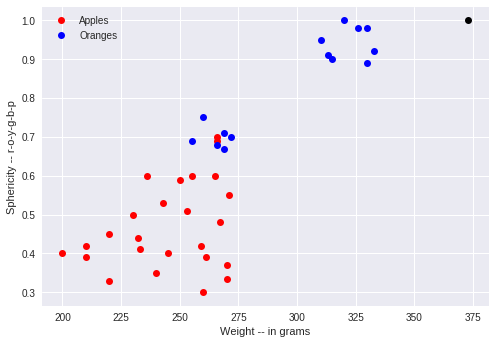

In [16]:
plt.plot(apples.Weight, apples.Sphericity, "ro")
plt.plot(oranges.Weight, oranges.Sphericity, "bo")
plt.xlabel("Weight -- in grams")
plt.ylabel("Sphericity -- r-o-y-g-b-p")
plt.legend(["Apples", "Oranges"])
plt.plot([373], [1], "ko")
plt.show()

From the visualization alone, we can infer that the unknown fruit is likely to be an Orange. 

The job now is to instead of eyeballing it one at a time like above, use a kNN classifier with, say, $k = 3$ and using the *Euclidean* distance, to determine the correct label for the data in the file  "kNN_weight_sphericity_test.csv"

Let us first write a distance function to calculate the *Euclidean* distance between two fruits.

$distance$ = $sqrt(\Sigma(a_i -b_i)^2)$

In [0]:
import math
def dist(a, b):
    ''' a is the n-dimesnional co-ordinate of point 1
        b is the n-dimensional co-ordinate of point 2'''
    sqSum = 0
    for i in range(len(a)):
        sqSum += (a[i] - b[i]) ** 2
    return math.sqrt(sqSum)

Now let us write code to find the $k$ nearest neighbours of a given fruit

In [0]:
def kNN(k, train, given):
    distances = []
    for t in train.values:              
        # loop over all training samples
        distances.append((dist(t[:2], given), t[2])) 
        # compute and store distance of each training sample from the given sample
    distances.sort()            
    return distances[:k]    # return first k samples = nearest  k distances to the given sample

In [37]:
print(kNN(3, train, (373, 1)))
print(kNN(5, train, (373, 1)))

[(40.00007999992, 'O'), (43.00000465116254, 'O'), (43.00014069744424, 'O')]
[(40.00007999992, 'O'), (43.00000465116254, 'O'), (43.00014069744424, 'O'), (47.000004255318956, 'O'), (53.0, 'O')]


** Try entering other sample entry for example " print(kNN(3,train, (250,1))) "**

As you can see above, the 3 (and 5) nearest neighbours of the fruit with the characteristics (373, 1) are all Oranges -- label 1; which is what we visually saw when we plotted the point as a black spot in the chart. Of course we need to write another function to get this attribute rather than read, so we have written a function for that. We have used collections.Counter, which we explored in the earlier experiment.

In [41]:
import collections
def kNNmax(k, train, given):
    tally = collections.Counter()
    for nn in kNN(k, train, given):
        tally.update(nn[-1])

    return tally.most_common(1)[0]
print(kNNmax(5, train, (340, 1)))
print(kNNmax(7, train, (340, 1)))

('O', 5)
('O', 7)


Now let us load the test data and find the labels for all of them. Also let us count how many are correct.

In [44]:
testData = pd.read_csv(FRUITS_TEST1).values[:,:-1]
testResults = pd.read_csv(FRUITS_TEST1).values[:,-1]
results = []
for i, t in enumerate(testData):
    results.append(kNNmax(3, train, t)[0] == testResults[i])
print(results.count(True), "are correct")

18 are correct


Text(0.5,1,'Linear Classfier')

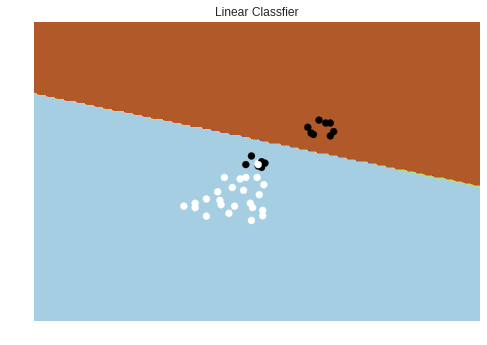

In [22]:
#@title Linear classifiers learn a separating hyperplane from the training samples. Run the following cell to create a Linear Classifier and plot the output.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

X2 = train.iloc[:,:-1].values#np.array([[2,1],[3,4],[4,2],[3,1]])
X=scaler.fit_transform(X2)


Y = le.fit_transform(train.iloc[:,-1].values)
h = .02  # step size in the mesh

#clf2 = Perceptron(max_iter=1000).fit(X, Y)
clf2 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

clf2.fit(X,Y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
fig, ax = plt.subplots()
Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)
ax.axis('off')

# Plot also the training points
ax.scatter(X[:, 0], X[:, 1], c=Y)

ax.set_title('Linear Classfier')

**Exercise 1** :: Repeat the above experiment with $k = 5$ and $k = 7$. Explain which $k$ is better and why?

In [25]:
## Your code here

results = []
for i, t in enumerate(testData):
    results.append(kNNmax(5, train, t)[0] == testResults[i])
print(results.count(True), "are correct")

results = []
for i, t in enumerate(testData):
    results.append(kNNmax(7, train, t)[0] == testResults[i])
print(results.count(True), "are correct")


18 are correct
18 are correct


**Exercise 2** :: Repeat the above experiment with $k = 17$. What do you think is happening?

In [45]:
## Your code here
results = []
for i, t in enumerate(testData):
    results.append(kNNmax(17, train, t)[0] == testResults[i])
print(results.count(True), "are correct")


18 are correct


**Exercise 3** :: Modify the distance function to ignore the colour feature. Calculate the accuracy on the smaller test dataset.

In [0]:
def dist(a, b):
  sqSum = 0
  sqSum += (a[0] - b[0]) ** 2
  return math.sqrt(sqSum)

  
    ## Your code here

In [47]:
## Your code here

results = []
for i, t in enumerate(testData):
    results.append(kNNmax(3, train, t)[0] == testResults[i])
print(results.count(True), "are correct")



18 are correct


**Exercise 4** :: If we used the square of the Euclidean distance, for the distance fuction does it affect the accuracy?

In [48]:
## Your code here

def dist(a, b):
  sqSum = 0
  for i in range(len(a)):
    sqSum += (a[i] - b[i]) ** 2
  return sqSum

results = []
for i, t in enumerate(testData):
    results.append(kNNmax(3, train, t)[0] == testResults[i])
print(results.count(True), "are correct")

18 are correct



**Exercise 5** :: If we use the sum of the absolute differences, as the distance metric instead of the Euclidean, how does that affect the accuracy?

In [50]:
## Your code here
def dist(a, b):
  sqSum = 0
  for i in range(len(a)):
    sqSum += abs(a[i]-b[i])
  return sqSum
results = []
for i, t in enumerate(testData):
    results.append(kNNmax(3, train, t)[0] == testResults[i])
print(results.count(True), "are correct")

18 are correct


## Summary
In the above experiment, we find that 
 * a simple nearest neighbour method can successfully predict labels with a small number of labelled examples. We also demo a Linear Classifier that separates the two classes, for the same data.
 * But we also see that the results can go really wrong 
    - if we make some wrong choices (like weight in Kg, or a very large K).

This should remind you about the practical expertise and experimental skills that will become equally important as we move forward.